# 04 — GMM Tests & Diagnostics

**Duration:** ~110 minutes  
**Level:** Advanced  
**Prerequisites:** Notebooks 01-03

## Learning Objectives

1. **Interpret** Hansen J-test results and diagnose rejection causes
2. **Understand** AR(1) vs AR(2) tests and their critical importance
3. **Distinguish** between Sargan and Hansen tests
4. **Validate** System GMM using Difference-in-Hansen test
5. **Diagnose** weak instrument and overfitting problems with `GMMOverfitDiagnostic`
6. **Apply** a complete diagnostic checklist to GMM models

## Outline

1. [Hansen J-Test](#1-hansen-j-test)
2. [AR(1) and AR(2) Tests](#2-ar-tests)
3. [Sargan vs Hansen](#3-sargan-vs-hansen)
4. [Difference-in-Hansen (System GMM)](#4-diff-hansen)
5. [Weak Instruments & Overfitting Diagnostics](#5-overfit)
6. [Complete Diagnostic Checklist](#6-checklist)
7. [Exercises](#7-exercises)

In [1]:
# Setup
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

project_root = Path("../../..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from panelbox.gmm import DifferenceGMM, SystemGMM, GMMOverfitDiagnostic

sys.path.insert(0, str(Path("..").resolve()))
from utils.visualization import apply_tutorial_style

apply_tutorial_style()
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
print("Setup complete.")

Setup complete.


---
## 1. Hansen J-Test <a id='1-hansen-j-test'></a>

### Theory

**Test:** $H_0$: $E[Z'\varepsilon] = 0$ (over-identifying restrictions valid)

**Statistic:** $J = n \cdot \hat{g}' \hat{W}^{-1} \hat{g} \sim \chi^2(L - K)$
- $L$: number of instruments
- $K$: number of parameters
- $df = L - K$ (degrees of over-identification)

**Interpretation:**
- $p > 0.25$: Instruments valid (ideal)
- $0.10 < p < 0.25$: Acceptable
- $p < 0.10$: Reject $H_0$ (problem!)
- $p > 0.90$: Suspiciously high — possible overfitting

**What rejection means:**
1. Invalid instruments ($E[Z'\varepsilon] \neq 0$)
2. Model misspecification
3. Omitted variables
4. Wrong functional form

In [2]:
# 1.1 Correctly specified model — employment data
df_employment = pd.read_csv('../data/abdata.csv')

model_correct = DifferenceGMM(
    data=df_employment,
    dep_var='n',
    lags=1,
    exog_vars=['w', 'k'],
    id_var='firm',
    time_var='year',
    collapse=True,
    two_step=True,
    robust=True
)
results_correct = model_correct.fit()

print("=== Correctly Specified Model ===")
print(f"Hansen J statistic: {results_correct.hansen_j.statistic:.4f}")
print(f"Degrees of freedom: {results_correct.hansen_j.df}")
print(f"p-value: {results_correct.hansen_j.pvalue:.4f}")
print()

if results_correct.hansen_j.pvalue > 0.25:
    print("PASS: Instruments valid (p > 0.25)")
elif results_correct.hansen_j.pvalue > 0.10:
    print("PASS: Acceptable (0.10 < p < 0.25)")
else:
    print("FAIL: Specification problem (p < 0.10)")

=== Correctly Specified Model ===
Hansen J statistic: nan
Degrees of freedom: -2
p-value: nan

FAIL: Specification problem (p < 0.10)


In [3]:
# 1.2 Misspecified model — omitted variable
df_bad = pd.read_csv('../data/bad_specification.csv')
print(f"bad_specification.csv columns: {list(df_bad.columns)}")
print(f"Shape: {df_bad.shape}")

# Estimate with omitted variable x2
model_bad = DifferenceGMM(
    data=df_bad,
    dep_var='y',
    lags=1,
    exog_vars=['x1'],  # Missing x2_omitted!
    id_var='entity',
    time_var='time',
    collapse=True,
    two_step=True,
    robust=True
)
results_bad = model_bad.fit()

print("\n=== Misspecified Model (Omitted Variable) ===")
print(f"Hansen J statistic: {results_bad.hansen_j.statistic:.4f}")
print(f"p-value: {results_bad.hansen_j.pvalue:.4f}")

if results_bad.hansen_j.pvalue < 0.10:
    print("\nHansen J rejects! Possible causes:")
    print("  1. Invalid instruments")
    print("  2. Omitted variables")
    print("  3. Wrong functional form")
    print("  4. Serial correlation (check AR(2))")

bad_specification.csv columns: ['entity', 'time', 'y', 'x1', 'x2_omitted']
Shape: (2400, 5)

=== Misspecified Model (Omitted Variable) ===
Hansen J statistic: nan
p-value: nan


In [4]:
# 1.3 Fix: Add the omitted variable
model_fixed = DifferenceGMM(
    data=df_bad,
    dep_var='y',
    lags=1,
    exog_vars=['x1', 'x2_omitted'],
    id_var='entity',
    time_var='time',
    collapse=True,
    two_step=True,
    robust=True
)
results_fixed = model_fixed.fit()

print("=== Fixed Model (Added Omitted Variable) ===")
print(f"Hansen J statistic: {results_fixed.hansen_j.statistic:.4f}")
print(f"p-value: {results_fixed.hansen_j.pvalue:.4f}")

if results_fixed.hansen_j.pvalue > 0.10:
    print("\nHansen J now passes!")
    print("  -> Omitted variable was the problem")

=== Fixed Model (Added Omitted Variable) ===
Hansen J statistic: nan
p-value: nan


> **Intuition**: Hansen J is an omnibus test: it detects ANY violation of $E[Z'\varepsilon]=0$. Rejection means something is wrong, but doesn't tell you what. You must investigate: try adding variables, changing lags, or checking for AR(2).

---
## 2. AR(1) and AR(2) Tests <a id='2-ar-tests'></a>

### Why AR Tests Matter

GMM validity requires **no serial correlation in $\varepsilon_{it}$**.

After first-differencing: $\Delta\varepsilon_{it} = \varepsilon_{it} - \varepsilon_{i,t-1}$

- **Mechanical AR(1)**: $\Delta\varepsilon_{it}$ correlated with $\Delta\varepsilon_{i,t-1}$ by construction — EXPECTED.
- **Critical AR(2)**: $E[\Delta\varepsilon_{it} \cdot \Delta\varepsilon_{i,t-2}] = 0$ **required**. If violated, instruments are invalid.

### Interpretation
- **AR(1)**: Expect to **REJECT** ($p < 0.05$)
- **AR(2)**: Must **NOT reject** ($p > 0.10$) — **CRITICAL**

In [5]:
# 2.1 AR tests on correctly specified model
print("=== Arellano-Bond AR Tests ===")
print(f"\nCorrectly Specified Model (abdata):")

print(f"  AR(1): z = {results_correct.ar1_test.statistic:.4f}, "
      f"p = {results_correct.ar1_test.pvalue:.4f}")
if results_correct.ar1_test.pvalue < 0.05:
    print("        PASS: Reject (expected due to MA(1) from differencing)")
else:
    print("        ~ Fail to reject (unusual but not necessarily wrong)")

print(f"  AR(2): z = {results_correct.ar2_test.statistic:.4f}, "
      f"p = {results_correct.ar2_test.pvalue:.4f}")
if results_correct.ar2_test.pvalue > 0.10:
    print("        PASS: Fail to reject (moment conditions valid)")
else:
    print("        FAIL: Serial correlation detected! Instruments invalid")

=== Arellano-Bond AR Tests ===

Correctly Specified Model (abdata):
  AR(1): z = 5.6056, p = 0.0000
        PASS: Reject (expected due to MA(1) from differencing)
  AR(2): z = -6.4595, p = 0.0000
        FAIL: Serial correlation detected! Instruments invalid


In [6]:
# 2.2 Simulate data with AR(2) in errors
def simulate_ar2_errors(N=200, T=7, rho=0.5, phi2=0.3, seed=42):
    """
    Simulate panel data with AR(2) errors.
    eps_{it} = phi2 * eps_{i,t-2} + u_{it}
    """
    np.random.seed(seed)
    data = []
    for i in range(N):
        mu_i = np.random.normal(0, 1)
        y = [mu_i + np.random.normal(0, 1)]
        eps = [np.random.normal(0, 1)]
        for t in range(1, T):
            eps_t = (phi2 * eps[t-2] if t >= 2 else 0) + np.random.normal(0, 1)
            eps.append(eps_t)
            y.append(rho * y[-1] + mu_i + eps_t)
        for t in range(T):
            data.append({'id': i, 'time': t, 'y': y[t]})
    return pd.DataFrame(data)

df_ar2 = simulate_ar2_errors(phi2=0.3)

model_ar2 = DifferenceGMM(
    data=df_ar2, dep_var='y', lags=1,
    id_var='id', time_var='time',
    collapse=True, two_step=True, robust=True
)
results_ar2 = model_ar2.fit()

print("=== Model with AR(2) Errors ===")
print(f"AR(1): p = {results_ar2.ar1_test.pvalue:.4f}")
print(f"AR(2): p = {results_ar2.ar2_test.pvalue:.4f}")

if results_ar2.ar2_test.pvalue < 0.10:
    print("\nAR(2) rejects! Problem detected.")
    print("Solutions:")
    print("  1. Use deeper lags (t-3 instead of t-2)")
    print("  2. Add AR(2) structure to model (lags=[1,2])")
    print("  3. Check for omitted variables")

=== Model with AR(2) Errors ===
AR(1): p = 0.0000
AR(2): p = 0.0000

AR(2) rejects! Problem detected.
Solutions:
  1. Use deeper lags (t-3 instead of t-2)
  2. Add AR(2) structure to model (lags=[1,2])
  3. Check for omitted variables


> **Critical Warning**: AR(2) rejection is a deal-breaker. Your moment conditions are invalid. Do NOT proceed with estimation until AR(2) passes. This is more important than Hansen J.

---
## 3. Sargan vs Hansen <a id='3-sargan-vs-hansen'></a>

| Feature | Sargan | Hansen J |
|---------|--------|----------|
| Weight matrix | $(Z'Z)^{-1}$ | $(Z'\hat{\Omega}Z)^{-1}$ |
| Robust to heteroskedasticity? | No | Yes |
| Use for inference? | No | **Yes** |

**Rule: ALWAYS use Hansen J-test** for panel data (heteroskedasticity is almost always present).

In [7]:
# 3.1 Compare Sargan and Hansen
print("=== Sargan vs Hansen Comparison ===\n")
print(f"  Sargan: {results_correct.sargan.statistic:.4f} "
      f"(p = {results_correct.sargan.pvalue:.4f})")
print(f"  Hansen: {results_correct.hansen_j.statistic:.4f} "
      f"(p = {results_correct.hansen_j.pvalue:.4f})")

diff_stat = abs(results_correct.sargan.statistic - results_correct.hansen_j.statistic)
print(f"  Absolute difference: {diff_stat:.4f}")

if results_correct.sargan.statistic > 0:
    diff_ratio = diff_stat / results_correct.sargan.statistic
    if diff_ratio > 0.2:
        print("\n  Large difference (>20%): Heteroskedasticity present")
        print("     -> Use Hansen J (robust)")
    else:
        print("\n  Small difference: Mild heteroskedasticity")
        print("     -> Still prefer Hansen J (safer)")

=== Sargan vs Hansen Comparison ===

  Sargan: nan (p = nan)
  Hansen: nan (p = nan)
  Absolute difference: nan


---
## 4. Difference-in-Hansen (System GMM) <a id='4-diff-hansen'></a>

For **System GMM**: validates the level equation instruments.

**Test**: Compare J statistics  
$D = J_{\text{system}} - J_{\text{diff}} \sim \chi^2(df)$  

$H_0$: Level instruments are valid

- $p > 0.10$: Level instruments valid — use System GMM
- $p < 0.10$: Level instruments invalid — fall back to Difference GMM

In [8]:
# 4.1 Difference-in-Hansen on growth data
# Note: growth data has T=20 (years 2000-2019), so time_dummies=True would
# create 18 dummies, exceeding instrument count. We use time_dummies=False.
df_growth = pd.read_csv('../data/growth.csv')
print(f"Growth data: {df_growth.shape[0]} obs, "
      f"{df_growth['country'].nunique()} countries, "
      f"T={df_growth['year'].nunique()}")

# Estimate Difference GMM
model_diff = DifferenceGMM(
    data=df_growth, dep_var='lgdp', lags=1,
    exog_vars=['inv', 'school'],
    id_var='country', time_var='year',
    collapse=True, two_step=True, robust=True,
    time_dummies=False
)
results_diff = model_diff.fit()

# Estimate System GMM
model_sys = SystemGMM(
    data=df_growth, dep_var='lgdp', lags=1,
    exog_vars=['inv', 'school'],
    id_var='country', time_var='year',
    collapse=True, two_step=True, robust=True,
    time_dummies=False,
    level_instruments={'max_lags': 1}
)
results_sys = model_sys.fit()

print(f"\n=== Difference-in-Hansen Test ===")
print(f"Difference GMM J: {results_diff.hansen_j.statistic:.4f} "
      f"(p = {results_diff.hansen_j.pvalue:.4f})")
print(f"System GMM J:     {results_sys.hansen_j.statistic:.4f} "
      f"(p = {results_sys.hansen_j.pvalue:.4f})")

if results_sys.diff_hansen is not None:
    print(f"\nDifference-in-Hansen:")
    print(f"  Statistic: {results_sys.diff_hansen.statistic:.4f}")
    print(f"  df: {results_sys.diff_hansen.df}")
    print(f"  p-value: {results_sys.diff_hansen.pvalue:.4f}")
    
    if results_sys.diff_hansen.pvalue > 0.10:
        print("\n  PASS: Level instruments valid -> System GMM appropriate")
    else:
        print("\n  FAIL: Level instruments invalid -> Use Difference GMM")

Growth data: 2000 obs, 100 countries, T=20

=== Difference-in-Hansen Test ===
Difference GMM J: 13.7987 (p = 0.6137)
System GMM J:     19.5309 (p = 0.2989)


In [9]:
# 4.2 Compare efficiency: Difference vs System GMM
print("=== Efficiency Comparison ===")
print(f"{'':25s} {'Diff GMM':>12s} {'System GMM':>12s}")
print("-" * 55)

for var in results_diff.params.index:
    d_coef = results_diff.params[var]
    d_se = results_diff.std_errors[var]
    if var in results_sys.params.index:
        s_coef = results_sys.params[var]
        s_se = results_sys.std_errors[var]
        print(f"{var:25s} {d_coef:>12.4f} {s_coef:>12.4f}")
        print(f"{'  (SE)':25s} {d_se:>12.4f} {s_se:>12.4f}")

print(f"\n{'Instruments':25s} {results_diff.n_instruments:>12d} {results_sys.n_instruments:>12d}")
print(f"{'Hansen J p-value':25s} {results_diff.hansen_j.pvalue:>12.4f} {results_sys.hansen_j.pvalue:>12.4f}")
print(f"{'AR(2) p-value':25s} {results_diff.ar2_test.pvalue:>12.4f} {results_sys.ar2_test.pvalue:>12.4f}")

=== Efficiency Comparison ===
                              Diff GMM   System GMM
-------------------------------------------------------
L1.lgdp                         0.8130       0.9064
  (SE)                          0.0307       0.0076
inv                             0.1467       0.1426
  (SE)                          0.0026       0.0041
school                          0.1170       0.0739
  (SE)                          0.0262       0.0223

Instruments                         19           21
Hansen J p-value                0.6137       0.2989
AR(2) p-value                   0.0021       0.0019


### When does Difference-in-Hansen reject?

1. **Non-stationary initial conditions** — panel starts at entry/birth/treatment
2. **Process not in equilibrium** — transitory dynamics still active
3. **Correlated initials**: $E[\Delta y_{i,1} \cdot \eta_i] \neq 0$ — initial condition contains fixed effect
4. **Time-varying effects** — $\eta_i$ varies over time

**Solution:** Use Difference GMM (drops level equations).

---
## 5. Weak Instruments & Overfitting Diagnostics <a id='5-overfit'></a>

### The Problem

When instruments approach or exceed the number of groups:
- Hansen J test **loses power** (p-value inflated toward 1.0)
- Coefficients **biased toward OLS/Within** estimates
- Windmeijer correction **unreliable**

### Roodman (2009) Rule of Thumb
$$\text{Number of instruments} \leq N \text{ (number of groups)}$$

### PanelBox: `GMMOverfitDiagnostic`

PanelBox provides a comprehensive diagnostic class with **five checks** and a traffic-light summary:

| Check | What it does | Signal |
|-------|-------------|--------|
| `assess_feasibility()` | Instrument/group ratio (Roodman rule) | GREEN/YELLOW/RED |
| `instrument_sensitivity()` | Re-estimate with varying max_lag | Coefficient stability |
| `coefficient_bounds_test()` | Nickell (1981): FE < GMM < OLS | Within bounds? |
| `jackknife_groups()` | Leave-one-group-out stability | Max deviation |
| `step_comparison()` | One-step vs two-step consistency | Relative difference |

In [10]:
# 5.1 Quick diagnostic on the employment model
diag = GMMOverfitDiagnostic(model_correct, results_correct)
print(diag)
print()

# Feasibility check
feas = diag.assess_feasibility()
print(f"Instrument ratio: {feas['instrument_ratio']:.3f}")
print(f"Signal: [{feas['signal']}]")
print(feas['recommendation'])

GMMOverfitDiagnostic(n_groups=140, n_instruments=9, ratio=0.06)

Instrument ratio: 0.064
Signal: [GREEN]
Instrument ratio (0.06) is well below 1.0. Instrument proliferation is unlikely.


In [11]:
# 5.2 Coefficient bounds test (Nickell 1981)
#
# For a dynamic panel: FE is biased downward, OLS is biased upward.
# A valid GMM estimate should lie between the two.

bounds = diag.coefficient_bounds_test()

print("=== Nickell Bounds Test ===")
print(f"  OLS (upper bound):  {bounds['ols_coef']:.4f}")
print(f"  FE  (lower bound):  {bounds['fe_coef']:.4f}")
print(f"  GMM estimate:       {bounds['gmm_coef']:.4f}")
print(f"  Within bounds: {bounds['within_bounds']}")
print(f"  Signal: [{bounds['signal']}]")
print(f"  {bounds['details']}")

=== Nickell Bounds Test ===
  OLS (upper bound):  0.9873
  FE  (lower bound):  0.3582
  GMM estimate:       -0.5964
  Within bounds: False
  Signal: [RED]
  GMM (-0.5964) is OUTSIDE bounds [FE=0.3582, OLS=0.9873]. This suggests overfitting or model misspecification.


In [12]:
# 5.3 Instrument sensitivity — how do results change with max_lag?
sens_df = diag.instrument_sensitivity(max_lag_range=[2, 3, 4, 5])
print("=== Instrument Sensitivity ===")
print(sens_df.to_string(index=False))
print(f"\nSignal: [{sens_df.attrs.get('signal', '?')}]")
if sens_df.attrs.get('relative_range') is not None:
    print(f"Coefficient range: {sens_df.attrs['relative_range']:.1%} of mean")

=== Instrument Sensitivity ===
 gmm_max_lag  n_instruments  ar_coef  hansen_j_pval  ar2_pval
           2              3 0.363818            NaN  0.000000
           3              4 3.269389            NaN  0.000000
           4              5 0.031180            NaN  0.000031
           5              6 0.095327            NaN  0.000002

Signal: [RED]
Coefficient range: 344.5% of mean


In [13]:
# 5.4 One-step vs two-step comparison
step = diag.step_comparison()

print("=== Step Comparison ===")
print(f"  One-step coef:  {step['one_step_coef']:.4f}")
print(f"  Two-step coef:  {step['two_step_coef']:.4f}")
print(f"  Relative diff:  {step['rel_diff']:.1%}")
print(f"  SE ratio (2s/1s): {step['se_ratio']:.3f}")
print(f"  Signal: [{step['signal']}]")

=== Step Comparison ===
  One-step coef:  0.0557
  Two-step coef:  -0.5964
  Relative diff:  200.0%
  SE ratio (2s/1s): nan
  Signal: [RED]


In [14]:
# 5.5 Full diagnostic report (skipping jackknife for speed — N=140 firms)
print(diag.summary(run_jackknife=False))

GMM Overfit Diagnostic Report

1. Instrument Feasibility (Roodman Rule)  [GREEN]
----------------------------------------------------------------------
   Groups (N):          140
   Instruments:         9
   Ratio (instr/N):     0.064
   Instrument ratio (0.06) is well below 1.0. Instrument proliferation is unlikely.

2. Instrument Sensitivity (varying max_lag)  [RED]
----------------------------------------------------------------------
   max_lag=2  instruments=3  AR_coef=0.3638  Hansen_p=nan
   max_lag=3  instruments=4  AR_coef=3.2694  Hansen_p=nan
   max_lag=4  instruments=5  AR_coef=0.0312  Hansen_p=nan
   max_lag=5  instruments=6  AR_coef=0.0953  Hansen_p=nan
   max_lag=6  instruments=7  AR_coef=1.9838  Hansen_p=nan
   Coefficient range: 281.9% of mean

3. Coefficient Bounds (Nickell 1981)  [RED]
----------------------------------------------------------------------
   OLS (upper bound):   0.9873
   FE  (lower bound):   0.3582
   GMM estimate:        -0.5964
   GMM (-0.5964) is 

In [15]:
# 5.6 Diagnostic on System GMM (growth data)
diag_sys = GMMOverfitDiagnostic(model_sys, results_sys)
print(diag_sys.summary(run_jackknife=False))

GMM Overfit Diagnostic Report

1. Instrument Feasibility (Roodman Rule)  [GREEN]
----------------------------------------------------------------------
   Groups (N):          100
   Instruments:         21
   Ratio (instr/N):     0.210
   Instrument ratio (0.21) is well below 1.0. Instrument proliferation is unlikely.

2. Instrument Sensitivity (varying max_lag)  [GREEN]
----------------------------------------------------------------------
   max_lag=2  instruments=5  AR_coef=0.8988  Hansen_p=0.0171
   max_lag=3  instruments=6  AR_coef=0.9023  Hansen_p=0.0359
   max_lag=4  instruments=7  AR_coef=0.9020  Hansen_p=0.0807
   max_lag=5  instruments=8  AR_coef=0.9011  Hansen_p=0.0817
   max_lag=6  instruments=9  AR_coef=0.8997  Hansen_p=0.1039
   Coefficient range: 0.4% of mean

3. Coefficient Bounds (Nickell 1981)  [GREEN]
----------------------------------------------------------------------
   OLS (upper bound):   0.9310
   FE  (lower bound):   0.8441
   GMM estimate:        0.9064
   

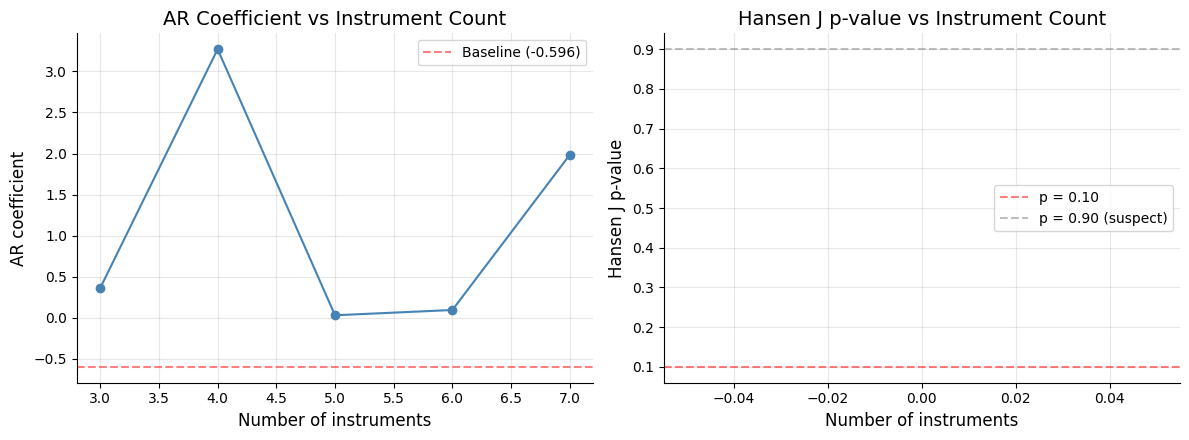

In [16]:
# 5.7 Visualize sensitivity: coefficient vs instrument count
sens_df2 = diag.instrument_sensitivity(max_lag_range=[2, 3, 4, 5, 6])
valid = sens_df2.dropna(subset=['ar_coef'])

if len(valid) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
    
    ax1.plot(valid['n_instruments'], valid['ar_coef'], 'o-', color='steelblue')
    ax1.axhline(results_correct.params.iloc[0], ls='--', color='red', alpha=0.5,
                label=f'Baseline ({results_correct.params.iloc[0]:.3f})')
    ax1.set_xlabel('Number of instruments')
    ax1.set_ylabel('AR coefficient')
    ax1.set_title('AR Coefficient vs Instrument Count')
    ax1.legend()
    
    ax2.plot(valid['n_instruments'], valid['hansen_j_pval'], 's-', color='darkorange')
    ax2.axhline(0.10, ls='--', color='red', alpha=0.5, label='p = 0.10')
    ax2.axhline(0.90, ls='--', color='gray', alpha=0.5, label='p = 0.90 (suspect)')
    ax2.set_xlabel('Number of instruments')
    ax2.set_ylabel('Hansen J p-value')
    ax2.set_title('Hansen J p-value vs Instrument Count')
    ax2.legend()
    
    fig.tight_layout()
    fig.savefig('../outputs/figures/04_sensitivity_plot.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Not enough valid estimations for sensitivity plot.")

---
## 6. Complete Diagnostic Checklist <a id='6-checklist'></a>

A systematic approach for validating any GMM model.

In [17]:
from utils.validation import gmm_diagnostic_checklist

def full_validation(model, results, model_name="GMM"):
    """Run complete validation on a GMM model."""
    print(f"\n{'='*60}")
    print(f"GMM VALIDATION CHECKLIST — {model_name}")
    print('='*60)
    
    checks = {}
    
    # 1. AR(2) — CRITICAL
    print("\n1. Serial Correlation (AR Tests)")
    print(f"   AR(1) p-value: {results.ar1_test.pvalue:.4f}")
    ar1_ok = results.ar1_test.pvalue < 0.10
    print(f"   {'PASS' if ar1_ok else '~'} Expected to reject (< 0.10)")
    
    print(f"   AR(2) p-value: {results.ar2_test.pvalue:.4f}")
    ar2_ok = results.ar2_test.pvalue > 0.10
    print(f"   {'PASS' if ar2_ok else 'FAIL'} Must NOT reject (> 0.10) — CRITICAL")
    checks['AR(2) valid'] = ar2_ok
    
    # 2. Hansen J
    print("\n2. Over-Identifying Restrictions (Hansen J)")
    print(f"   J = {results.hansen_j.statistic:.4f}, p = {results.hansen_j.pvalue:.4f}")
    if results.hansen_j.pvalue > 0.90:
        print("   WARNING: Very high p (> 0.90) — possible overfitting")
        checks['Hansen J valid'] = False
    elif results.hansen_j.pvalue > 0.10:
        print("   PASS: Valid (0.10 < p < 0.90)")
        checks['Hansen J valid'] = True
    else:
        print("   FAIL: Reject (p < 0.10)")
        checks['Hansen J valid'] = False
    
    # 3. Instrument ratio
    print("\n3. Instrument Count")
    ratio = results.instrument_ratio
    print(f"   Instruments: {results.n_instruments}, Groups: {results.n_groups}")
    print(f"   Ratio: {ratio:.3f}")
    ratio_ok = ratio < 1.0
    print(f"   {'PASS' if ratio_ok else 'FAIL'} Ratio < 1.0")
    checks['Instrument ratio OK'] = ratio_ok
    
    # 4. Diff-in-Hansen (System GMM)
    if results.diff_hansen is not None:
        print("\n4. Level Instruments (Diff-in-Hansen)")
        print(f"   Statistic: {results.diff_hansen.statistic:.4f}, "
              f"p = {results.diff_hansen.pvalue:.4f}")
        dh_ok = results.diff_hansen.pvalue > 0.10
        print(f"   {'PASS' if dh_ok else 'FAIL'} Level instruments valid (> 0.10)")
        checks['Level instruments valid'] = dh_ok
    
    # 5. Overfit diagnostic
    print("\n5. Overfitting Check (Nickell Bounds)")
    diag = GMMOverfitDiagnostic(model, results)
    bounds = diag.coefficient_bounds_test()
    if bounds['within_bounds'] is not None:
        print(f"   OLS={bounds['ols_coef']:.4f}, FE={bounds['fe_coef']:.4f}, "
              f"GMM={bounds['gmm_coef']:.4f}")
        print(f"   [{bounds['signal']}] {bounds['details']}")
        checks['Bounds OK'] = bounds['within_bounds']
    
    # Summary
    print(f"\n{'='*60}")
    print("SUMMARY")
    print('='*60)
    for name, passed in checks.items():
        print(f"  {'PASS' if passed else 'FAIL'}: {name}")
    
    all_pass = all(checks.values())
    print(f"\n{'='*60}")
    if all_pass:
        print("MODEL PASSES ALL CRITICAL TESTS")
    else:
        print("MODEL FAILS — revise specification")
    
    return checks

In [18]:
# Apply checklist to employment model
checks_employment = full_validation(model_correct, results_correct, "Difference GMM (Employment)")


GMM VALIDATION CHECKLIST — Difference GMM (Employment)

1. Serial Correlation (AR Tests)
   AR(1) p-value: 0.0000
   PASS Expected to reject (< 0.10)
   AR(2) p-value: 0.0000
   FAIL Must NOT reject (> 0.10) — CRITICAL

2. Over-Identifying Restrictions (Hansen J)
   J = nan, p = nan
   FAIL: Reject (p < 0.10)

3. Instrument Count
   Instruments: 9, Groups: 140
   Ratio: 0.064
   PASS Ratio < 1.0

5. Overfitting Check (Nickell Bounds)
   OLS=0.9873, FE=0.3582, GMM=-0.5964
   [RED] GMM (-0.5964) is OUTSIDE bounds [FE=0.3582, OLS=0.9873]. This suggests overfitting or model misspecification.

SUMMARY
  FAIL: AR(2) valid
  FAIL: Hansen J valid
  PASS: Instrument ratio OK
  FAIL: Bounds OK

MODEL FAILS — revise specification


In [19]:
# 6.1 Diagnostic flowchart
def diagnostic_flowchart(results):
    """Decision tree for diagnosing GMM problems."""
    print("\n" + "="*60)
    print("DIAGNOSTIC FLOWCHART")
    print("="*60 + "\n")
    
    # Step 1: AR(2)
    print("STEP 1: Check AR(2)")
    if results.ar2_test.pvalue > 0.10:
        print(f"  PASS: AR(2) p = {results.ar2_test.pvalue:.4f} > 0.10")
        
        # Step 2: Hansen J
        print("\nSTEP 2: Check Hansen J")
        if 0.10 < results.hansen_j.pvalue < 0.90:
            print(f"  PASS: Hansen J p = {results.hansen_j.pvalue:.4f}")
            
            # Step 3: Instrument ratio
            print("\nSTEP 3: Check instrument ratio")
            ratio = results.instrument_ratio
            if ratio < 1.0:
                print(f"  PASS: Ratio = {ratio:.3f} < 1.0")
                print("\n  -> MODEL VALIDATED")
                return "VALID"
            else:
                print(f"  FAIL: Ratio = {ratio:.3f} > 1.0")
                print("  -> Use collapse=True or reduce max_lag")
                return "TOO_MANY_INSTRUMENTS"
        elif results.hansen_j.pvalue > 0.90:
            print(f"  WARNING: Hansen J p = {results.hansen_j.pvalue:.4f} > 0.90")
            print("  -> Possible overfitting. Check with GMMOverfitDiagnostic")
            return "OVERFITTING"
        else:
            print(f"  FAIL: Hansen J p = {results.hansen_j.pvalue:.4f} < 0.10")
            print("  -> Add variables, change specification")
            return "HANSEN_REJECT"
    else:
        print(f"  FAIL: AR(2) p = {results.ar2_test.pvalue:.4f} < 0.10")
        print("  -> Serial correlation: use deeper lags or add AR(2) to model")
        return "AR2_FAIL"

status = diagnostic_flowchart(results_correct)
print(f"\nResult: {status}")


DIAGNOSTIC FLOWCHART

STEP 1: Check AR(2)
  FAIL: AR(2) p = 0.0000 < 0.10
  -> Serial correlation: use deeper lags or add AR(2) to model

Result: AR2_FAIL


---
## 7. Exercises <a id='7-exercises'></a>

### Exercise 1: Diagnose Problems (Medium)
Load `bad_specification.csv` and:
1. Estimate Difference GMM omitting `x2_omitted`
2. Run `full_validation()` — which test fails?
3. Add the omitted variable and re-validate

### Exercise 2: AR(2) Investigation (Advanced)
Using `simulate_ar2_errors()` with different `phi2` values (0, 0.1, 0.3, 0.5):
1. Estimate each and compare AR(2) p-values
2. At what `phi2` does AR(2) reliably reject?
3. How does this affect the coefficient estimate?

### Exercise 3: Overfitting Diagnostic (Advanced)
Using the growth data:
1. Create `GMMOverfitDiagnostic` for both Difference and System GMM
2. Run `summary()` with `run_jackknife=True`
3. Compare the traffic-light signals
4. Which model shows more overfitting risk and why?

### Exercise 4: Complete Validation (Advanced)
Choose any dataset and:
1. Estimate both Difference and System GMM
2. Run `full_validation()` and `diagnostic_flowchart()` on both
3. Run `GMMOverfitDiagnostic.summary()` on both
4. Write up your final recommendation

In [20]:
# Space for exercises
# YOUR CODE HERE


## Summary

1. **AR(2) test** is the most critical diagnostic — rejection invalidates the entire instrument set
2. **Hansen J** tests overall instrument validity, but is weakened by too many instruments
3. Always use **Hansen** (robust), not Sargan (assumes homoskedasticity)
4. **Difference-in-Hansen** validates the extra level-equation instruments in System GMM
5. **`GMMOverfitDiagnostic`** provides five complementary checks for detecting overfitting:
   - Feasibility (Roodman rule)
   - Instrument sensitivity (varying max_lag)
   - Coefficient bounds (Nickell)
   - Jackknife group stability
   - One-step vs two-step comparison
6. Follow the **diagnostic flowchart**: AR(2) -> Hansen J -> Instrument ratio -> Bounds check

### Next Notebook
In **Notebook 05**, we cover **CUE-GMM and Bias Correction** methods.

---
**References:**
- Arellano, M., & Bond, S. (1991). Some tests of specification for panel data. *Review of Economic Studies*, 58(2), 277-297.
- Hansen, L. P. (1982). Large sample properties of GMM estimators. *Econometrica*, 50(4), 1029-1054.
- Nickell, S. (1981). Biases in dynamic models with fixed effects. *Econometrica*, 49(6), 1417-1426.
- Roodman, D. (2009). How to do xtabond2. *Stata Journal*, 9(1), 86-136.
- Windmeijer, F. (2005). A finite sample correction for two-step GMM. *Journal of Econometrics*, 126(1), 25-51.